In [1]:
# from google.colab import drive
# drive.mount('/content/gdrive')
!pip install pyPDF2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 460.0 kB/s eta 0:00:00 0:00:01m


In [2]:
!pip install tensorflow==2.15.0     #2.15.0 te kaaj kre    

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 6.5 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: keras
    Found existing installation: keras 3.0.5
    Uninstalling keras-3.0.5:
      Successfully uninstalled keras-3.0.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.8.1 requires wurlitzer, which is not installed.


In [7]:
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,TensorBoard,LambdaCallback
from keras.layers import Lambda, SeparableConv2D, GlobalAvgPool2D, Input, Average, ReLU, Dropout, DepthwiseConv2D, Dense, GlobalAvgPool2D, GlobalAveragePooling2D,Conv2D, ZeroPadding2D, BatchNormalization, Activation, MaxPooling2D, Flatten, AvgPool2D, Concatenate, MaxPool2D
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU


from keras.preprocessing import image

from glob import glob

from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot
from keras.models import Sequential,Model
import pandas as pd
# from keras.applications.resnet import ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
from tensorflow import keras
import tensorflow as tf
from tqdm import tqdm
import seaborn as sns
import numpy as np
import itertools
import time
import datetime
import os
import cv2
import io

from datetime import datetime
from keras.callbacks import ModelCheckpoint

# import imutils
import matplotlib.pyplot as plt
from os import listdir

from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler

from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

%matplotlib inline

In [8]:
# Set the path to the dataset
# dataset_path = "C:/Users/USER/ML/Latest/def_data"
dataset_path = "/kaggle/input/brain-tumor-mri-dataset"

# Define the training and testing directories
train_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Training")
test_dir = os.path.join(dataset_path, "/kaggle/input/brain-tumor-mri-dataset/Testing")

# Define the categories
categories = ["glioma", "meningioma", "notumor", "pituitary"]

In [10]:
# Set the image size
image_size = (150, 150)

# Set the batch size for training
batch_size = 32

# Set the number of epochs for training
epochs = 50

In [12]:
# Data augmentation and preprocessing
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode="nearest"
)

train_set = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical"
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_set = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode="categorical",
    shuffle=False
)

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.


In [13]:
DenseNet121 = tf.keras.applications.densenet.DenseNet121(input_shape=(150, 150, 3),
            weights='imagenet',
            include_top=False)

29084464/29084464 [==============================] - 0s 0us/step


In [14]:
for layer in DenseNet121.layers:
    layer.trainable = False

In [15]:
folders = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
print(len(folders))

4


In [24]:
x = DenseNet121.output
x = GlobalAveragePooling2D()(x)
# x = Dropout(0.4)(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
prediction = Dense(len(folders), activation='softmax')(x)
model = Model(inputs=DenseNet121.input, outputs=prediction)

In [25]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d (ZeroPaddin  (None, 156, 156, 3)          0         ['input_1[0][0]']             
 g2D)                                                                                             
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d[0][0]']      
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1/conv[0][0]']    

In [26]:
# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001, verbose=1)

In [27]:
# Define callbacks
DenseNet121_checkpoint = ModelCheckpoint(filepath='DenseNet121_checkpoint.h5', 
                                       monitor='val_accuracy', 
                                       verbose=1, 
                                       save_best_only=True, 
                                       mode='max')

DenseNet121_callbacks = [DenseNet121_checkpoint, reduce_lr]

start = datetime.now()

In [28]:
# adam = keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [29]:
# Train the model
history = model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=epochs,
    validation_data=test_set,
    validation_steps=test_set.samples // batch_size,
    callbacks=DenseNet121_callbacks
)
duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/50
178/178 [==============================] - ETA: 0s - loss: 0.5655 - accuracy: 0.8072
Epoch 1: val_accuracy improved from -inf to 0.77266, saving model to DenseNet121_checkpoint.h5
178/178 [==============================] - 61s 301ms/step - loss: 0.5655 - accuracy: 0.8072 - val_loss: 0.6891 - val_accuracy: 0.7727 - lr: 0.0010
Epoch 2/50
178/178 [==============================] - ETA: 0s - loss: 0.3435 - accuracy: 0.8708
Epoch 2: val_accuracy improved from 0.77266 to 0.85859, saving model to DenseNet121_checkpoint.h5
178/178 [==============================] - 50s 281ms/step - loss: 0.3435 - accuracy: 0.8708 - val_loss: 0.4262 - val_accuracy: 0.8586 - lr: 0.0010
Epoch 3/50
178/178 [==============================] - ETA: 0s - loss: 0.3127 - accuracy: 0.8796
Epoch 3: val_accuracy improved from 0.85859 to 0.87344, saving model to DenseNet121_checkpoint.h5
178/178 [==============================] - 50s 282ms/step - loss: 0.3127 - accuracy: 0.8796 - val_loss: 0.3874 - val_accuracy: 

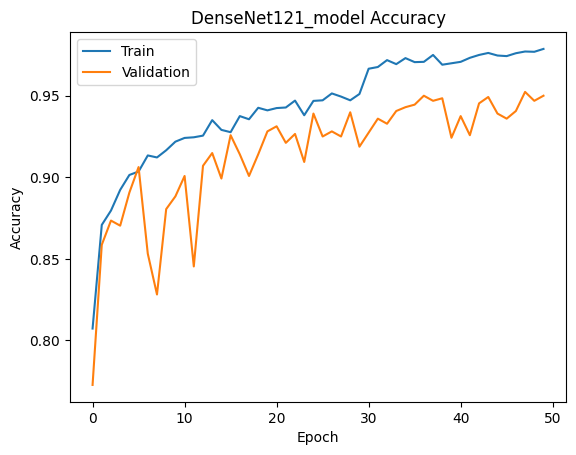

In [31]:
# Plot the training and validation accuracy over epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('DenseNet121_model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

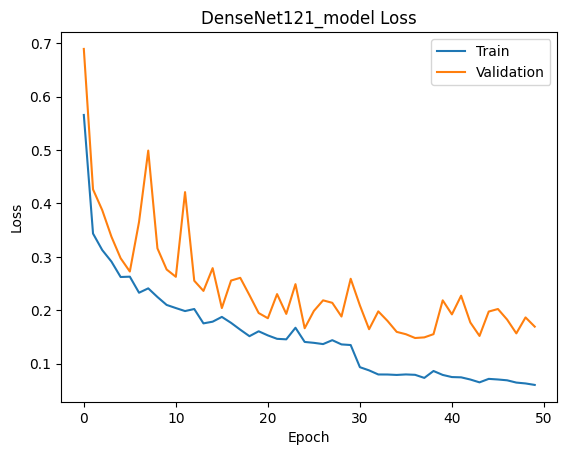

In [32]:
# Plot the training and validation loss over epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('DenseNet121_model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.show()

In [33]:
# Evaluate the model
loss, accuracy = model.evaluate(test_set, steps=test_set.samples // batch_size)
# loss, accuracy = model.evaluate(test_set, steps=32)

print("DenseNet121_model Test Loss:", loss)
print("DenseNet121_model Test Accuracy:", accuracy)

40/40 [==============================] - 5s 122ms/step - loss: 0.1693 - accuracy: 0.9500
DenseNet121_model Test Loss: 0.16931383311748505
DenseNet121_model Test Accuracy: 0.949999988079071


41/41 [==============================] - 9s 178ms/step
[0 0 0 ... 3 3 3]


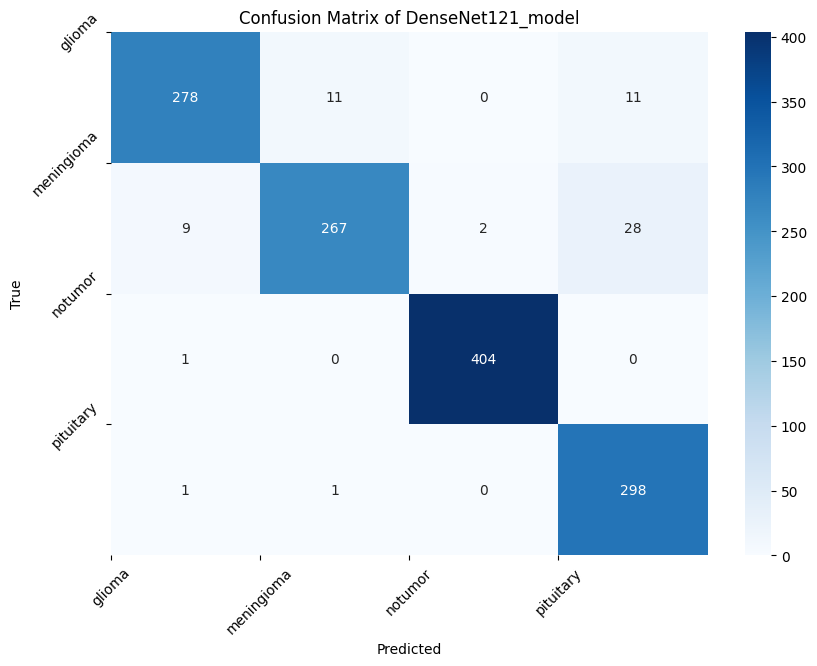

[ 660  767   69  895  738  398 1222  205  779]


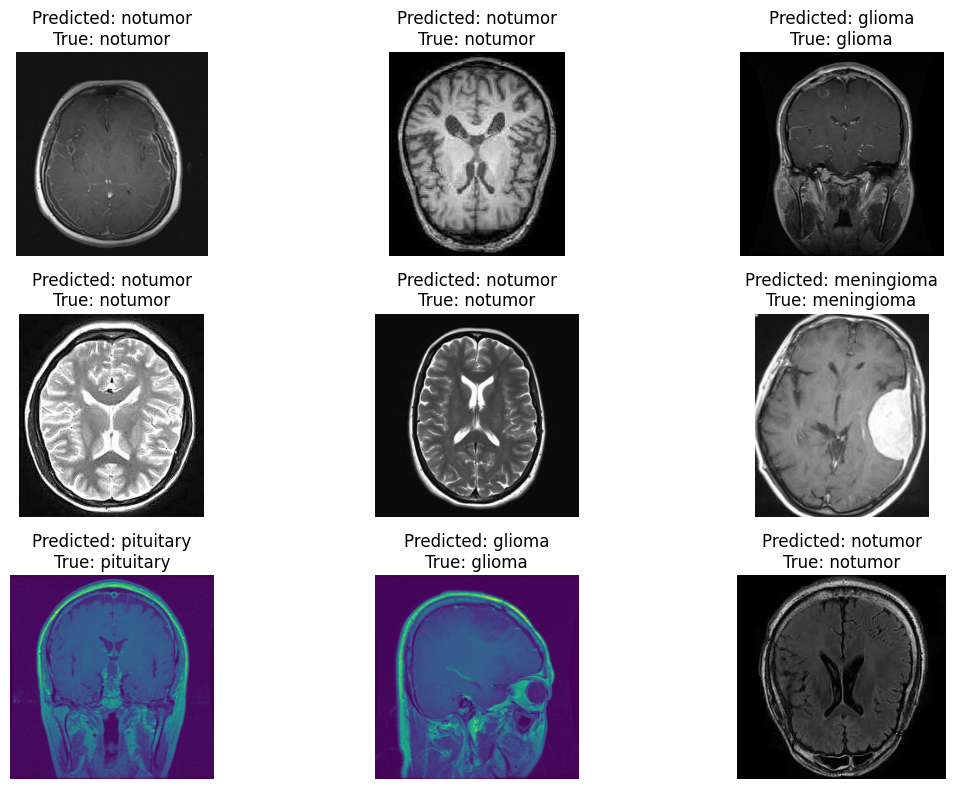

In [34]:
# Make predictions on the test dataset
predictions = model.predict(test_set)
predicted_categories = np.argmax(predictions, axis=1)

true_categories = test_set.classes
print(true_categories)

# Create a confusion matrix
confusion_matrix = tf.math.confusion_matrix(true_categories, predicted_categories)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix of DenseNet121_model")
plt.tight_layout() #########
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.yticks(ticks=np.arange(len(categories)), labels=categories, rotation=45)
plt.show()

# Plot sample images with their predicted and true labels
test_images = test_set.filenames
sample_indices = np.random.choice(range(len(test_images)), size=9, replace=False)
print(sample_indices)
sample_images = [test_images[i] for i in sample_indices]
sample_predictions = [categories[predicted_categories[i]] for i in sample_indices]
sample_true_labels = [categories[true_categories[i]] for i in sample_indices]

plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}")
    plt.axis("off")
plt.tight_layout()
plt.show()

Class: glioma
Precision: 0.9619377162629758
Recall: 0.9266666666666666
F1-Score: 0.9439728353140917

Class: meningioma
Precision: 0.956989247311828
Recall: 0.8725490196078431
F1-Score: 0.9128205128205128

Class: notumor
Precision: 0.9950738916256158
Recall: 0.9975308641975309
F1-Score: 0.9963008631319359

Class: pituitary
Precision: 0.884272997032641
Recall: 0.9933333333333333
F1-Score: 0.9356357927786499



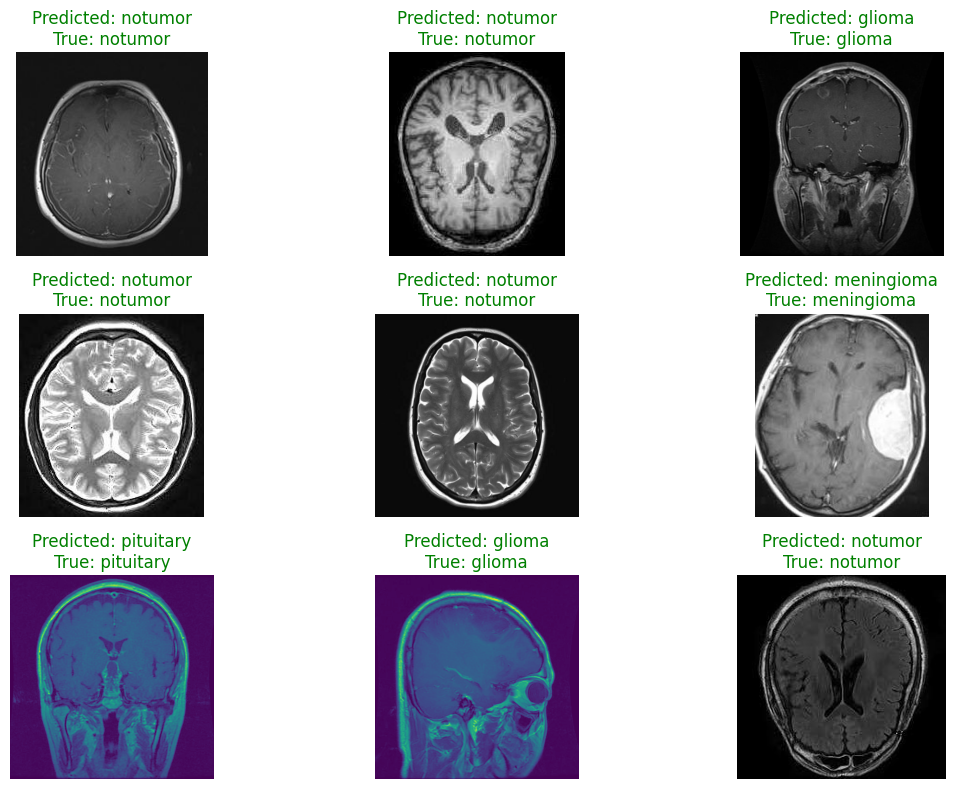

In [35]:
# Calculate precision, recall, and F1-score from the confusion matrix
precision = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=0)
recall = np.diag(confusion_matrix) / np.sum(confusion_matrix, axis=1)
f1_score = 2 * (precision * recall) / (precision + recall)

# Print precision, recall, and F1-score for each class
for i, category in enumerate(categories):
    print(f"Class: {category}")
    print(f"Precision: {precision[i]}")
    print(f"Recall: {recall[i]}")
    print(f"F1-Score: {f1_score[i]}")
    print()

# Analyze the sample images and their predictions
plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    img = plt.imread(os.path.join(test_dir, sample_images[i]))
    plt.imshow(img)
    if sample_predictions[i] == sample_true_labels[i]:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='green')
    else:
        plt.title(f"Predicted: {sample_predictions[i]}\nTrue: {sample_true_labels[i]}", color='red')
    plt.axis("off")
plt.tight_layout()
plt.show()

4


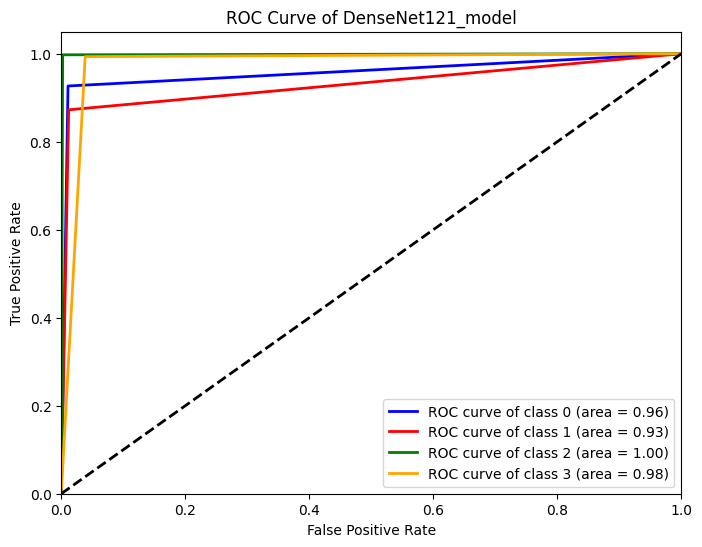

In [36]:
from sklearn.metrics import roc_curve, auc
from keras.models import load_model
from sklearn.preprocessing import label_binarize

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes = glob('/kaggle/input/brain-tumor-mri-dataset/Training/*')
num_classes = len(classes)
print(num_classes)

Y_test_bin = label_binarize(true_categories, classes=np.arange(4))
Y_pred_bin = label_binarize(predicted_categories, classes=np.arange(4))

for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_bin[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
colors = ['blue', 'red', 'green', 'orange']  # Add more colors if you have more classes

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,label='ROC curve of class {0} (area = {1:0.2f})'''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve of DenseNet121_model')
plt.legend(loc="lower right")

plt.show()

In [ ]:
# Save the trained model
model.save("DenseNet121_model_brain_tumor_detection.h5")